# Tutorial 3: Shallow Circuits

##### After going through this 1 hour tutorial you will:

- know what a universal quantum gate set is
- be able to decompose quantum gates using universal gate sets
- know how to manually initialize quantum states
- know [pyQuil](https://github.com/rigetticomputing/pyquil)'s quantum algorithm library [Grove](https://github.com/rigetticomputing/grove)
- understand how to simulate Hamiltonians on universal quantum computers

As always, we first need to make sure that we set up our API key & user ID in order to be able to use Rigetti's servers.

In [ ]:
import os

API_KEY = 'YOUR API KEY GOES HERE'
USER_ID = 'YOUR USER ID GOES HERE'

PYQUIL_CONFIG = f"""
[Rigetti Forest]
url: https://api.rigetti.com/qvm
key: {API_KEY}
user_id: {USER_ID}
"""

with open(os.path.expanduser('~/.pyquil_config'), 'w') as f:
    f.write(PYQUIL_CONFIG)

***
## 1. Universal quantum gate set

Most near-term quantum computers have a limited set of quantum gates which can be implemented on the hardware level. For example, Rigetti implements only two single-qubit and one two-qubit gate on the QPU. More specifically, these are $RZ(\theta)$, $RX(\frac{k\pi}{2})$, and a controlled $Z$ ($CZ$) defined as:

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$R_Z(\theta) = \begin{bmatrix}
    e^{-i\frac{\theta}{2}} & 0 \\
    0 & e^{i\frac{\theta}{2}}
    \end{bmatrix}$$
    
$$R_X(\frac{k\pi}{2}) = \begin{bmatrix}
    \cos\frac{k\pi}{4} & -i\sin\frac{k\pi}{4} \\
    -i\sin\frac{k\pi}{4} & \cos\frac{k\pi}{4}
    \end{bmatrix}$$
    
$$CZ = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & -1 \\
    \end{bmatrix}$$

At first, this set of quantum gates might seem very small. Especially considering that we just learned in Lecture II that there are infinitely many quantum gates (since the only requirement is unitarity)! However, there is a very important theorem at the core of quantum theory:

###### The Solovay-Kitaev theorem
Let $G$ be a universal quantum set consisting of quantum gates from SU(2) and
let $\epsilon > 0$ be a desired accuracy. Then there is a constant $b$ such that for any single-qubit
gate $W \in$ $SU(2)$ there exists a finite gate sequence $\tilde{G}$ of gates from the set $G$ of length
$\mathcal{O}(\log^b (\frac{1}{\epsilon}))$ such that $d(W, \tilde{G}) < \epsilon$. In their proof, Dawson and Nielsen (2005) show that $b \approx 3.97$.

In other words, using a universal quantum gate set we can approximate a circuit containing $m$ CNOTs and single qubit unitaries to an accuracy $\epsilon$ with $\mathcal{O}(m \log^b (\frac{m}{\epsilon}))$ gates. That's a polylogarithmic increase in size compared to the original circuit which is very acceptable for almost all applications.

And of course Rigetti's set of three quantum gates is universal. **Hence, any quantum circuit can be constructed from this universal set of quantum gates!**

***

In Lecture II on quantum gates and notation we've been discussing the four Pauli gates I, X, Y and Z as well as the Hadamard gate. For the next exercises, we've manually implemented these four gates as matrices using `numpy.matrix`:

In [ ]:
import numpy as np

pauli_I = np.matrix([[1, 0],[0, 1]])
print(f'Identity gate matrix: \n {pauli_I} \n')
pauli_X = np.matrix([[0, 1],[1, 0]])
print(f'Pauli X gate matrix: \n {pauli_X} \n')
pauli_Y = np.matrix([[0, -1j],[1j, 0]])
print(f'Pauli Y gate matrix: \n {pauli_Y} \n')
pauli_Z = np.matrix([[1, 0],[0, -1]])
print(f'Pauli Z gate matrix: \n {pauli_Z} \n')
hadamard = np.matrix([[0.707, 0.707],[0.707, -0.707]])
print(f'Hadamard gate matrix: \n {hadamard} \n')

##### Exercise 1.0
For which value of $\theta$ does $RZ(\theta)$ represent the Pauli Z gate?

In [ ]:
import cmath

# manual definition of Rigetti's parametrized RZ gate. no need to modify.
rz = lambda theta: np.matrix([[cmath.exp(-1j*theta/2), 0],[0, cmath.exp(1j*theta/2)]])

theta = ? # TODO: find the right value for theta

print(f'RZ with theta={theta} results in the following matrix: \n\n {1j*rz(theta)} \n')
print(f'Subtracting RZ with theta={theta} from pauli_Z results in: \n\n {np.round(1j*rz(theta)-pauli_Z)}')

##### Exercise 1.1
For which integer value of $k$ does $RX(\phi)$ with $\phi=\frac{k\pi}{2}$ represent the Pauli X gate?

In [ ]:
# manual definition of Rigetti's parametrized RX gate. no need to modify.
rx = lambda phi: np.matrix([[cmath.cos(phi/2), -1j*cmath.sin(phi/2)],[-1j*cmath.sin(phi/2), cmath.cos(phi/2)]])

k = ? # TODO: find the right value for k (must be an integer)

phi = k*cmath.pi/2 # do NOT modify (this is Rigetti's RX parametrization)
print(f'RX with k={k} results in the following matrix: \n\n {1j*rx(phi)}')
print(f'Subtracting RX with k={k} from pauli_X results in: \n\n {np.round(1j*rx(phi)-pauli_X)}')

***
## 2. Quantum gate decomposition

To fully grasp the implications of the Solovay-Kitaev theorem you will manually decompose several gates in this section.

##### Exercise 2.0
Use the definitions of Rigetti's $RZ(\theta)$ and $RX(\frac{k\pi}{2})$ gates above to find a combination (product) of gates that implements the Hadamard (H) on Rigetti's QPU! As a recap here is the matrix representation of the Hadamard gate:
$$H = \frac{1}{\sqrt{2}} \begin{bmatrix}
    1 & 1 \\
    1 & -1
    \end{bmatrix}  \approx  \begin{bmatrix}
    0.707 & 0.707 \\
    0.707 & -0.707
    \end{bmatrix}$$

<a title="Try multiplying the resulting matrix with the imaginary number i (remember that global phase doesn't matter) in order to get the correct result.">Hint.</a>

In [ ]:
# TODO: play with these two values (theta and k)
theta = ?
k = ? # must be an integer

# the angle for the RX gate is fixed to integer multiple of pi/2
phi = k*cmath.pi/2

# TODO: make different products (use 2, 3 or 4 gates)
gate_product = rz(theta)*rx(phi)
print(f'The sequence of gates yields the matrix: \n \n {gate_product} \n')
print(f'Subtracting this sequence of gates from the Hadamard yields: \n \n {np.round(gate_product-hadamard)}')

#### Exercise 2.1:
[This paper by Garcia-Escartin and Chamorro-Posada](https://arxiv.org/pdf/1110.2998.pdf) is a great resource to understand the equivalence of a lot of different circuits. Among other useful things, they show that the following circuit involving a controlled-Z (CZ) gate is equivalent to a single CNOT operation:

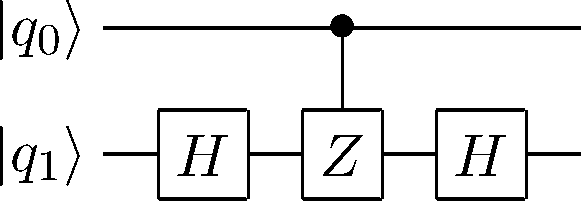

Use your decomposed Hadamard gate from the previous exercise to implement a $CNOT$ (up to an unimportant global phase) using a $CZ$ gate and parametrized RX and RZ gates in pyQuil!

**NOTE: Don't use the definitions of `rz` and `rx` from the previous exercises but rather use pyQuil's parametrized RX and RZ gates.**

In [ ]:
# from pyquil.api import CompilerConnection, get_devices
from pyquil.quil import Program
from pyquil.gates import RX, RZ, CZ, X
from pyquil.api import QVMConnection

# assuming the 0th qubit is the control qubit, a X gate on 0 turns the control qubit ON (1) or OFF (0)
p = Program().inst(X(0))

# TODO: create a circuit with RX, RZ and CZ that equals a single CNOT gate
p.inst(?)

# establish connection to QVM and get wavefunction
qvm = QVMConnection()
wavefunction = qvm.wavefunction(p)
print(f'The resulting wavefunction is: {wavefunction}')
print(wavefunction.plot())

***
## 3. Quantum state preparation

The goal of quantum state preparation is the ability to generate quantum states with arbitrary amplitude distributions. Formally speaking, given a complex non-zero amplitude vector $\mathbf{a} \in \mathbb{C}^N$ with components $a_i$ find an algorithm that takes the initial state $\ket{0}^{\otimes \log_2 N}$ and outputs the following state:
$$\ket{\Psi} = \sum^{N-1}_{i=0} \frac{a_i}{\mid \mathbf{a} \mid} \ket{i}$$
where $\ket{i}$ stands for $i$ in its binary representation.

#### Exercise 3.0:
Design and implement a quantum circuit that initializes the following quantum state:

$$ \ket{\Psi} = \frac{-i}{2} \, \ket{00} - \frac{i}{2} \, \ket{01} + \frac{i}{2} \, \ket{10} + \frac{i}{2} \,\ket{11} $$

<a title="Use pyQuil's wavefunction functionality to print the prepared quantum state.">Hint.</a>

In [ ]:
from pyquil.api import QVMConnection
from pyquil.gates import CNOT, H, Z
from pyquil.quil import Program

qvm = QVMConnection()
p = Program()

# TODO: initialize the quantum state with quantum gates

print(qvm.wavefunction(p))

#### Exercise 3.1:
Built a quantum circuit with a conditional measurement to construct the following quantum state:

$$ \ket{\Psi} = -\frac{1}{2} \,|001> -  \, \frac{1}{2} \,|011> + \, \frac{1}{2} \,|101> + \, \frac{1}{2} \,|111> $$

<a title="Look at the if_then() function to access the shared memory in order to perform a conditional measurement.">Hint.</a>

In [ ]:
from pyquil.api import QVMConnection
from pyquil.gates import CNOT, H, Z, CCNOT, X, CZ, I
from pyquil.quil import Program

qvm = QVMConnection()
p = Program()

# TODO: initialize the quantum state with quantum gates + conditional measurement

print(qvm.wavefunction(p))

***
## 4. Rigetti's Grove algorithms library

There is several algorithms for quantum state preparation in the literature. For example, see [1](https://arxiv.org/pdf/1706.02721.pdf), [2](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.73.012307), [3](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.87.067901), [4](https://arxiv.org/abs/quant-ph/0208112) and [5](https://link.springer.com/article/10.1023/A:1021695125245). You should definitely read them at some point since they offer great insight into the difficulties involved with quantum state preparation. As you will see, each of these algorithms comes with tradeoffs and you will have to decide which one fits your needs. Also keep in mind that near-term quantum computers limit the number of quantum gate operations you can perform due to decoherence (also called **quantum circuit depth**). Most of the above algorithms will have extensive resource requirements to ensure generality which will probably force you to do manual state preparation in order to ensure maximum efficiency.

At this point, we need to install [Grove](https://github.com/rigetticomputing/grove) - a Python library with plenty of quantum algorithms implemented in [pyQuil](https://github.com/rigetticomputing/pyquil). I highly recommend you to check out the Grove documentation since it is a great resource to learn about the individual quantum algorithms and their implementations!

In [ ]:
!pip install git+https://github.com/rigetticomputing/grove

#### Exercise 4.0:
Use Grove's arbitrary state generation algorithm to generate circuits for the quantum states in Exercises 3.0 and 3.1.

In [ ]:
# TODO: Use Grove to generate circuits

#### Exercise 4.1:
Print the generated circuits in Exercise 4.0 and compare them with the circuits that you designed by hand in section 3. Where you doing better or worse in terms of quantum circuit depth?

***
## 5. Quantum simulation

Errors in quantum computations are major hurdles for the development of a universal fault-tolerant quantum computer. There is a whole research field dedicated to what we call **quantum error correction**. The various types of error propagate differently through CNOT gates. In the following section we will analyze this in more detail and use it to our advantage to simulate simple local Hamiltonians.

### Example: Bit flip errors

A bit flip error is a undesired spontaneous flip of a qubit and equivalent to the application of an X gate. Consider the following **error-free circuit**:

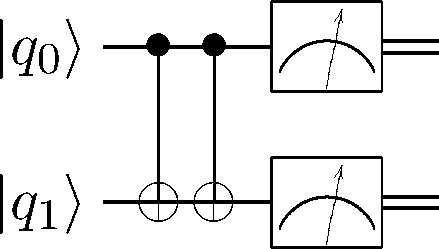

With an initial state of $\ket{00}$ we would also expect an output of $\ket{00}$ since two CNOTs are equal to the identity operation.

Now, let's assume a bit flip error on $q_0$ occurs between the two CNOT gates. The circuit with bit flip error then reads:

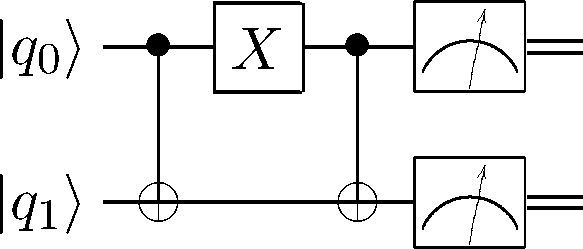

With an initial state of $\ket{00}$ we will know get an output of $\ket{11}$ which means **the bit flip error propagated downwards through the second CNOT gate**!

For the sake of completeness, let's also check the case when a bit flip error on $q_1$ (rather than $q_0$) occurs between the two CNOT gates. The circuit then looks like:

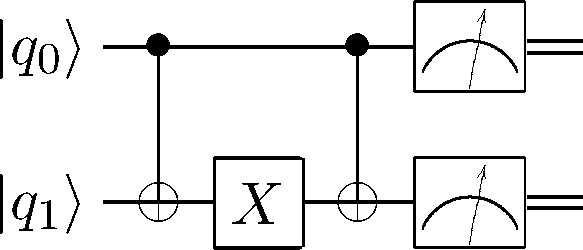

With an initial state of $\ket{00}$ we will know get an output of $\ket{01}$ which implies that a bit flip error does not travel upwards through a CNOT. Hence, we conclude that a bit flip error only propagates downwards through CNOT gates.

#### Exercise 5.0:
Phase flip errors propagate upwards through CNOT gates. Verify this statement with pen & paper and/or with pyQuil by implementing a short circuit that:

- initializes an equal superposition over all 2-qubit strings,
- applies a phase (Z) gate to one of the qubits,
- applies a CNOT gate to the two qubits,
- observe how the phase flip propagates.

In [ ]:
from pyquil.api import QVMConnection
from pyquil.gates import CNOT, H, Z, CCNOT, X, CZ, I
from pyquil.quil import Program

qvm = QVMConnection()
p = Program()

print(qvm.wavefunction(p))

#### Exercise 5.1:
We can exploit the fact that phase flip errors propagate upwards to simulate local Hamiltonians with many-body interactions such as:

$$ H = \gamma \big( Z_0 \otimes Z_1 \otimes Z_2 \big) $$

Implement a quantum circuit with at least three qubits in pyQuil that simulates the Hamiltonian above. <a title="Check out pages 209-211 in Nielsen & Chuang.">Hint.</a>

In [ ]:
# TODO: simulate the Hamiltonian above

***
## 6. Bonus exercises

#### Bonus Exercise 6.0:
Find the Toffoli decomposition with the lowest T count possible (small number of $T$ gates) by using [Nielsen & Chuang](http://www-reynal.ensea.fr/docs/iq/QC10th.pdf) or other resources. Implement the following two circuits with pyQuil to verify if the decomposition is correct:

- single Toffoli gate
- decomposed Toffoli

Using the three different input states: $\ket{000},
\ket{010},
\ket{001},
\ket{011}$

In [ ]:
# Write code here.